In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Ramping with I
ISIs = [0.4] * 4
ISI_pts = np.cumsum(ISIs)

# Constants
I0 = 1.5
beta = 3.0
alpha = 1.0

# Initialize
IS = I0
IP = I0
y0 = 0.7

# For storage
yS_lst = []
IS_lst = []
IP_lst = []
productions = []

# Synchronization
for i in range(len(ISIs)):
    print('iteration #', i, 'current ISI = ', ISI_pts[i])
    # Period adjustment
    yS = IS * ISIs[i]
    IS_new = IS - beta * (yS - y0)
    print('yS = ', yS, 'IS_new = ', IS_new)
    yS_lst.append(yS)
    IS_lst.append(IS_new)
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    # Calculate y_out of SAM
    if i == 0:
        y_out = IS_new * (np.sum(productions)) # Assume ISI_pts[i-1] = 0 here
    else:
        if ISI_pts[i] < np.sum(productions):
            y_out = IS_new * (np.sum(productions) - ISI_pts[i-1])
        else:
            y_out = IS_new * (np.sum(productions) - ISI_pts[i-1])
    
    print('y_out = ', y_out)
    
    IP = IS_new - alpha * (y0 - y_out)
    IS = IS_new
    IP_lst.append(IP)
    print('IP = ', IP)
    
    
    
# Continuation
n_continuation = 5
yS_inf = 1.0
for i in range(n_continuation):
    # Period adjustment: IS unchanged since no stimulus is observed
    yout = yS_inf
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    IP = IS - alpha * (y0 - yout)
    IP_lst.append(IP)
    print('IP = ', IP)
    

    








iteration # 0 current ISI =  0.4
yS =  0.6000000000000001 IS_new =  1.7999999999999996
tp =   0.4666666666666666
y_out =  0.8399999999999997
IP =  1.9399999999999995
iteration # 1 current ISI =  0.8
yS =  0.7199999999999999 IS_new =  1.7399999999999998
tp =   0.3608247422680413
y_out =  0.7438350515463915
IP =  1.7838350515463914
iteration # 2 current ISI =  1.2000000000000002
yS =  0.696 IS_new =  1.7519999999999998
tp =   0.3924129640760091
y_out =  0.7356724615147762
IP =  1.7876724615147759
iteration # 3 current ISI =  1.6
yS =  0.7008 IS_new =  1.7495999999999996
tp =   0.39157061210578714
y_out =  0.7199166339598353
IP =  1.769516633959835
tp =   0.3955882564570957
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496


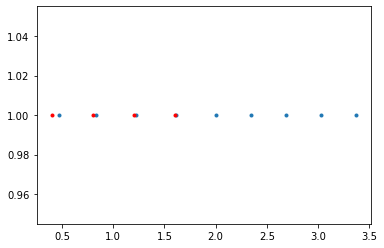

In [3]:
# Plot the result
plt.plot(np.cumsum(productions), np.ones(len(productions)), '.')
plt.plot(ISI_pts, np.ones(len(ISI_pts)) * 1.0, 'r.')

## Discrete updating algorithm

### Continuous time definitions
$y_{\textrm{ref}}$ : Reference level

$y_{\textrm{SAM}}$ : Output of SAM

$y_{\textrm{MPM}}$ : Output of of MPM

$I_{\textrm{SAM}}$ : Input to SAM

$I_{\textrm{MPM}}$ : Input to MPM


### Translation into discrete time
$i$ will index *time-points* and *intervals*

$t_p^i$ : time of $i$th production

$t_s^i$ : time of $i$th stimulus

$\textrm{ISI}^i$ = $t_s^{i+1} - t_s^i$

$\textrm{IPI}^i$ = $t_p^{i+1} - t_p^i$

$y_{\textrm{SAM}}^i=I_{\textrm{SAM}}^i*\textrm{ISI}^i$

$I_{\textrm{SAM}}^{i+1}=I_{\textrm{SAM}}^i+\beta(y_{\textrm{ref}}-y_{\textrm{SAM}}^i)$

$I_{\textrm{MPM}}^{i+1} = I_{\textrm{SAM}}^{i+1} + \alpha(y_{\textrm{out}}^i-y_{\textrm{MPM}}^i)$

$\textrm{IPI}^i=y_{\textrm{ref}}/I_{\textrm{MPM}}$

$t_p^{i+1}=t_p^i+\textrm{IPI}^i$

By definition $y_{\textrm{MPM}}^i=y_{\textrm{ref}}$ (output of $y_{\textrm{MPM}}$ at ith production)

The value of $y_{\textrm{out}}^i$ represents the output of the SAM at the time of the $i$th production. During synchronization that will be:

if $t_s^{i}<t_p^i$

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^{i}-t_s^{i})$

else

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^i-t_s^{i-1})$


During continuation:

$y_{\textrm{out}}^i = y_{\textrm{SAM}}^\infty$

with $y_{\textrm{SAM}}^\infty$ representing the terminal output of the SAM module.

In [79]:
# Definitions
def I_s_update(I_s_in,beta,y_ref,y_s):
    I_s_out = I_s_in + beta*(y_ref - y_s)
    
    return I_s_out

def I_p_update(I_s,alpha,y_p,y_out):
    I_p_out = I_s + alpha*(y_out-y_p)
    
    return I_p_out

def discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8, y_s_infty=1.5):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]
        
        if np.isnan(ISI[i]):
            y_s[i] = y_s_infty
            I_s[i+1] = I_s[i]
        else:
            y_s[i] = I_s[i]*ISI[i]
            I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        
        if np.isnan(ISI[i]):
            y_out = y_s_infty
        else:
            if t_s[i] < t_p[i]:
                y_out = I_s[i]*(t_p[i]-t_s[i])
            else:
                if i == 0:
                    y_out = y_ref
                else:
                    y_out = I_s[i]*(t_p[i]-t_s[i-1])
                #print(i,y_out)


        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        #print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

def discreteAlgorithm_modified(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]

        y_s[i] = I_s[i]*ISI[i]
        #print('i = ', i,'y_s = ', y_s[i], 'I_s = ', I_s[i])

        I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        if t_s[i] < t_p[i]:
            y_out = I_s[i]*(t_p[i]-t_s[i-1])
        else:
            if i == 0:
                y_out = y_ref
            else:
                y_out = I_s[i]*(t_p[i]-t_s[i-1])
            #print(i,y_out)


        #print('yout = ', y_out)
        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        #print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

## Synchronization to a constant ISI

### Algorithm with $t_p[i]-t_s[i]$ and $t_p[i]-t_s[i-1]$

In [89]:
# Simple synchronization
ISI_short = [0.5] * 10
ISI_long = [0.7] * 10

t_s1, t_p1, IPI1, _, _, _ = discreteAlgorithm(ISI_short, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)
t_s2, t_p2, IPI2, _, _, _ = discreteAlgorithm(ISI_long, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)



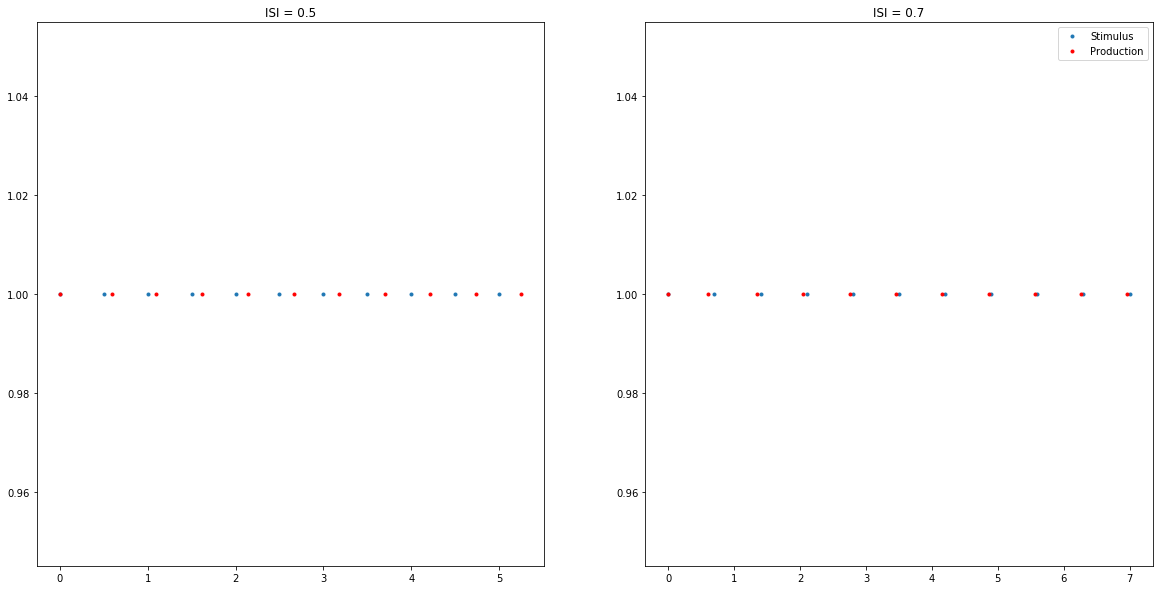

In [90]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(t_s1, np.ones(len(t_s1)), '.')
plt.plot(t_p1, np.ones(len(t_s1)),'r.')
plt.title('ISI = 0.5')

plt.subplot(122)
plt.plot(t_s2, np.ones(len(t_s2)), '.')
plt.plot(t_p2, np.ones(len(t_s2)),'r.')
plt.title('ISI = 0.7')
plt.legend(['Stimulus', 'Production'])

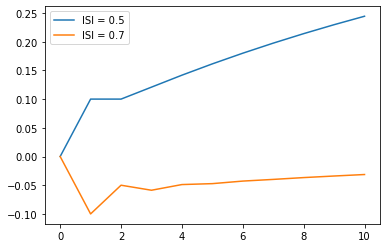

In [91]:
plt.plot(t_p1-t_s1)
plt.plot(t_p2 - t_s2)
plt.legend(['ISI = 0.5', 'ISI = 0.7'])

### Algorithm with $t_p[i]-t_s[i-1]$ only

In [92]:
# Simple synchronization
ISI_short = [0.5] * 10
ISI_long = [0.7] * 10

t_s1, t_p1, IPI1, _, _, _ = discreteAlgorithm_modified(ISI_short, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)
t_s2, t_p2, IPI2, _, _, _ = discreteAlgorithm_modified(ISI_long, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)

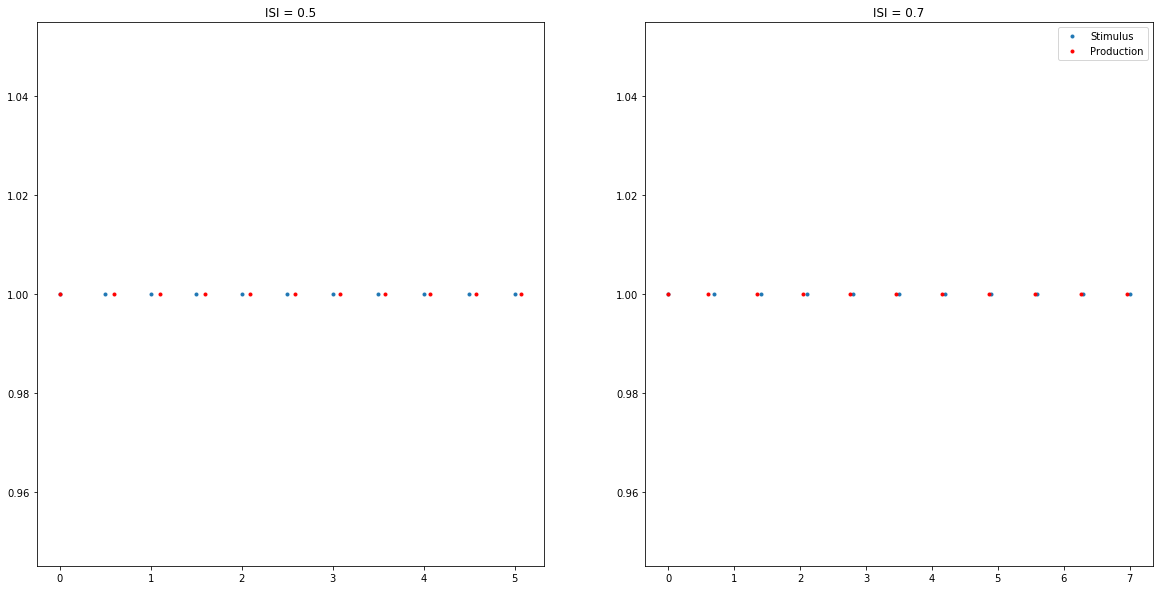

In [93]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(t_s1, np.ones(len(t_s1)), '.')
plt.plot(t_p1, np.ones(len(t_s1)),'r.')
plt.title('ISI = 0.5')

plt.subplot(122)
plt.plot(t_s2, np.ones(len(t_s2)), '.')
plt.plot(t_p2, np.ones(len(t_s2)),'r.')
plt.title('ISI = 0.7')
plt.legend(['Stimulus', 'Production'])

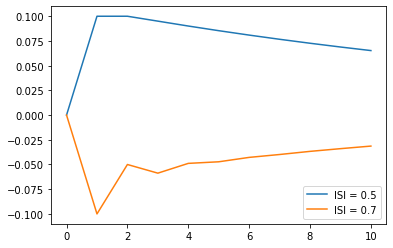

In [94]:
plt.plot(t_p1-t_s1)
plt.plot(t_p2 - t_s2)
plt.legend(['ISI = 0.5', 'ISI = 0.7'])